In [1]:
# because jackie's eCLIP is in hg19 we need to tell metadensity to switch coordinates
# if you are using some mysterious coordinates please see other tutorial on how to prepare the files :)
import metadensity as md
md.settings.root_dir = '/home/hsher/seqdata/20200622_gencode_coords_hsher/'
md.settings.transcript_fname = 'gencode.v19.transcript.gff3'
md.settings.gencode_feature_fname = 'gencode.v19.combine.sorted.gff3'

from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
# just to make sure it's hg19
transcript

<BedTool(/home/hsher/seqdata/20200622_gencode_coords_hsher/gencode.v19.transcript.gff3)>

# load the genes that kill the cell :)

In [3]:
myc=pd.read_excel('~/mut_all_screen_sig_genes.xlsx')

In [4]:
myc.head() # these are the genes when the genes are KD the cell die

,BRCA1_clone3,BRCA1_clone17,KRAS,MYC
0,RPL3,BRCA1,RPS11,PCBP2
1,MRPL45,CWC22,PIWIL1,UPF3B
2,BRCA1,RPL13A,RPS27,DCP2
3,RPL13A,RPL32,RPL7,IPO5
4,RPL32,DDX41,PPRC1,EIF4E2


# we need to manually create eCLIP object for these!!

In [38]:
base_dir = '/home/hsher/jackie_ythdf2/'
from metadensity.readdensity import ReadDensity
def make_eCLIP(cell_line):
    e = eCLIP()
    for rep, rname in zip([1,2], ['R1', 'R2']):
        for seq in ['CLIP', 'INPUT']:
            # put bigwig
            pos = '{}YTHDF2_trackhubs/hg19/YTHDF2.{}_{}_{}.umi.r1TrTr.sorted.STARUnmapped.out.sorted.STARAligned.outSo.rmDupSo.norm.{}.bw'.format(
            base_dir, seq, cell_line,rname, 'pos')
            neg = '{}YTHDF2_trackhubs/hg19/YTHDF2.{}_{}_{}.umi.r1TrTr.sorted.STARUnmapped.out.sorted.STARAligned.outSo.rmDupSo.norm.{}.bw'.format(
            base_dir, seq, cell_line,rname, 'neg')
            
            # bam
            bam = '{}YTHDF2.{}_{}_{}.umi.r1TrTr.sorted.STARUnmapped.out.sorted.STARAligned.outSo.rmDupSo.bam'.format(
            base_dir, seq, cell_line, rname)
            
            # create ReadDensity object
            density = ReadDensity(pos, neg, name = cell_line, bam = bam)
            
            # store into eCLIP object
            if seq == 'CLIP':
                key = 'rep{}'.format(rep)
                
            if seq == 'INPUT':
                key = 'ctrl{}'.format(rep)
            e.read_densities[key] = density
            
            # names
            e.name = cell_line
            e.uID = cell_line
            e.rep_keys = ['rep1', 'rep2']
            
            # individual rep peaks
            if seq == 'CLIP':
                
                fname = '{}YTHDF2.{}_{}_{}.umi.r1TrTr.sorted.STARUnmapped.out.sorted.STARAligned.outSo.rmDupSo.peakClusters.normed.bed'.format(
                    base_dir, seq, cell_line, rname)
                e.peaks[key] = BedTool(fname)
    # Intersect peaks
    
    fname = '{}idr_peaks/{}_1-{}_2.idr.final.bed'.format(base_dir, cell_line, cell_line)
    e.idr = BedTool(fname)
    print(fname)
    e.single_end = True
    
    return e

In [39]:
#For reference LM2 and MDA samples are MYC-dependent, MCF7 and SKBR3 are MYC independent
lm2 = make_eCLIP('LM2')
mda = make_eCLIP('MDA')
mcf7 = make_eCLIP('MCF7')
SKBR3 = make_eCLIP('SKBR3')

/home/hsher/jackie_ythdf2/idr_peaks/LM2_1-LM2_2.idr.final.bed
/home/hsher/jackie_ythdf2/idr_peaks/MDA_1-MDA_2.idr.final.bed
/home/hsher/jackie_ythdf2/idr_peaks/MCF7_1-MCF7_2.idr.final.bed
/home/hsher/jackie_ythdf2/idr_peaks/SKBR3_1-SKBR3_2.idr.final.bed


# Build Metagene for MYC only

In [15]:
myc = transcript.filter(lambda x: x.attrs['gene_name']=='MYC').saveas()
print(myc)

chr8	HAVANA	transcript	128748330	128753674	.	+	.	ID=ENST00000377970.2;Parent=ENSG00000136997.10;gene_id=ENSG00000136997.10;transcript_id=ENST00000377970.2;gene_type=protein_coding;gene_status=KNOWN;gene_name=MYC;transcript_type=protein_coding;transcript_status=KNOWN;transcript_name=MYC-001;level=2;protein_id=ENSP00000367207.2;tag=basic,CCDS;ccdsid=CCDS6359.2;havana_gene=OTTHUMG00000128475.3;havana_transcript=OTTHUMT00000250277.3;



In [16]:
myc_metagene = Build_many_metagene(myc)

Done Building Metagene


In [44]:
all_meta_raw = []
for e in [lm2, mda, mcf7, SKBR3]:
    m = Metadensity(e, myc, metagenes = myc_metagene, name = e.name, background_method = None, normalize = None) # raw read coverage in RPM
    m.get_density_array()
    all_meta_raw.append(m)

Text(0.5, 0.98, 'YTHDF2 Raw RPM on MYC gene')

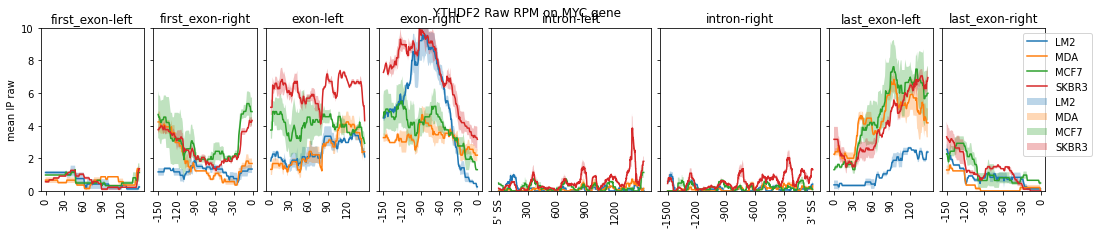

In [54]:
protein_coding = ['five_utr', 'first_CDS', 'CDS', 'last_CDS', 'three_utr']
rna = ['first_exon', 'exon', 'intron','last_exon']
f = plot_mean_density(all_meta_raw, features_to_show = rna, ymax = 10)
plt.suptitle('YTHDF2 Raw RPM on MYC gene')